In [1]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
import json

%matplotlib inline

DATAPATH = '../data/movie_metadata.json'

# Loading The Data

Open the json file and load it into memory. We also clean the data and separate it into two array - plots and genres. The json movie data file is then deleted as we have no reason to keep it in memory.

Split the genres to make a list, and remove whitespace from the entries. Example: 'Action, Adventure' splits to ['Action', ' Adventure'], the strip makes sure there is no ' Adventure' and we only get 'Adventure'.

In [2]:
## load in the data
with open(DATAPATH, 'r') as f:
    movie_data = json.load(f)

plots = []
genres = []
for movie in movie_data['data']:
    plots.append(movie['plot'])
    genres.append([genres.strip() for genres in movie['genres'].split(',')])

del movie_data

# Genres

Below you can see that we have about 26 unique genres. We may not want to use all of them, so we should only look at the genres that occur most frequently (maybe?). I think to start we may try them all, but looking only at the most frequent genres could be a helpful reduction in the data.

In [6]:
unique_genres, counts_genres = np.unique(np.concatenate(genres), return_counts=True)
print('GENRES')
print('------')
for genre in unique_genres:
    print(genre)
print('------')
print("Number of Unique Genres {}".format(len(unique_genres)))

GENRES
------
Action
Adventure
Animation
Biography
Comedy
Crime
Documentary
Drama
Family
Fantasy
Film-Noir
Game-Show
History
Horror
Music
Musical
Mystery
News
Reality-TV
Romance
Sci-Fi
Short
Sport
Thriller
War
Western
------
Number of Unique Genres 26


## Genre Frequency

There are a large number of genres that occur very infrequently, for instance we can see that the genres 'Game-Show' or 'Reality-TV' occur less than 1% of the time. It might be good to only look at genres that occur more than 1% or 5% of the time. As a side note, these rare generes could be a result of the wrong movie information - this should be rare though as we used IMDB IDs to search for the movie information. Or it could be a result of the movie, in the database we got them from, having incorrect or just mislabeled information. 

In [7]:
freq_genre = counts_genres/np.sum(counts_genres)
for combination in list(zip(unique_genres, freq_genre)):
    print(combination)

print('-------')
frequency_cut = 0.01
print('Genres occuring more than {}% of the time'.format(frequency_cut))
print(unique_genres[freq_genre > frequency_cut])

('Action', 0.092597038815526209)
('Adventure', 0.074429771908763501)
('Animation', 0.019367747098839535)
('Biography', 0.024009603841536616)
('Comedy', 0.1477390956382553)
('Crime', 0.070108043217286919)
('Documentary', 0.0094437775110044024)
('Drama', 0.20352140856342538)
('Family', 0.029851940776310523)
('Fantasy', 0.031372549019607843)
('Film-Noir', 0.00040016006402561027)
('Game-Show', 8.0032012805122043e-05)
('History', 0.012885154061624649)
('Horror', 0.043777511004401762)
('Music', 0.013765506202480992)
('Musical', 0.0056022408963585435)
('Mystery', 0.032412965186074429)
('News', 0.00016006402561024409)
('Reality-TV', 0.00016006402561024409)
('Romance', 0.069547819127651067)
('Sci-Fi', 0.032492997198879554)
('Short', 0.00040016006402561027)
('Sport', 0.010164065626250501)
('Thriller', 0.062825130052020811)
('War', 0.0085634253701480593)
('Western', 0.0043217286914765908)
-------
Genres occuring more than 0.01% of the time
['Action' 'Adventure' 'Animation' 'Biography' 'Comedy' 'C

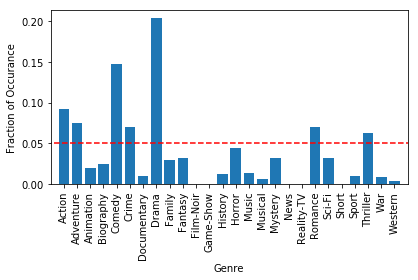

In [8]:
idx = np.arange(len(freq_genre))
space = 0.1

fig = plt.figure('')
ax = fig.add_subplot(111)
ax.bar(idx, freq_genre)
ax.set_xticks(idx)
ax.set_xticklabels(unique_genres, rotation='vertical')

ax.hlines(0.05, -5, np.max(idx)+5, colors='r', linestyles='dashed')
ax.set_xlim((-1, np.max(idx)+1))

ax.set_ylabel('Fraction of Occurance')
ax.set_xlabel('Genre')

plt.tight_layout()
plt.savefig('../intermediate_report/genre_fractions_v2p0.pdf')

## Removing Genres

If we do want to remove the genres that occur less frequently we can use the function below to do so.

Note: If we remove genres we will need to remove the movies that end up with no genre. Could find the indexes for these in the loop that looks like the one below.

In [9]:
def remove_genres(data, frequency_threshold=0.05):
    """
    Remove the genres that occur less that the frequency specified 
    amount of the time.
    
    Parameters
    ----------
    data: list
        list of genres
    frequency_threshold: float
    
    Returns
    -------
    data: list
    """
    
    unique_genres, counts_genres = np.unique(np.concatenate(data), return_counts=True)
    freq_genre = counts_genres/np.sum(counts_genres)
    keep_genres = set(unique_genres[freq_genre > frequency_threshold])
    
    genres = []
    for i in range(len(data)):
        genres.append(list(set(data[i]) & keep_genres))
    return genres
            
# for lst in remove_genres(genres, frequency_threshold=0.05):
#     if len(lst) == 0:
#         print(lst)

## Encoding the Genres

The final step is encoding the genres in uniform manner. This will be done using a one-hot encoding. For every movie create a vector, the length of the unique set of labels, filled with 1's where the movie has that genre and 0's where the movie does not have the genre.

Below is the function that turns the genres into a one_hot encoding.

['Action' 'Adventure' 'Comedy' 'Crime' 'Drama' 'Romance' 'Thriller']


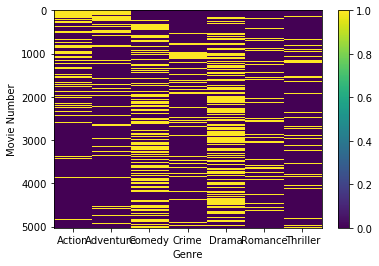

In [13]:
def one_hot(data):
    """
    Make a one-hot encoding of the genre data. Every
    movie should have a list of genres.
    
    Parameters
    ----------
    data: list
        a list of lists.
        
    Returns
    -------
    labels: np.array
        the labels associated with the list shape (len(unique_genres), )
    one_hot: np.array
        the one hot encoding, with shape (len(data), len(unique_genres))
    
    """
    labels = np.unique(np.concatenate(data))
    one_hot = np.zeros((len(data), len(labels)), dtype=bool)
    for i in range(len(data)):
        for j in range(len(data[i])):
            one_hot[i] += data[i][j] == labels
    return labels, one_hot.astype(int)

temp_genres = remove_genres(genres, 0.05)
labels, y = one_hot(temp_genres)
print(labels)

fig = plt.figure('Genres')
ax = fig.add_subplot(111)
temp = ax.imshow(y, aspect='auto')
l = ax.set_xticklabels([0]+list(labels))
ax.set_xlabel('Genre')
ax.set_ylabel('Movie Number')
plt.colorbar(temp)

# Features

In this section we create our feature matrix. 

## TF-IDF

Sklearn has many tools in the 'vectorizor' family. In many instances these takes lists of documents (sentences, paragraphs) and turn them into matrices. This is like doing $k$-grams on the data but they have the tool built out so it is really fast and can return you sparse matrices. There are a number of vectorizors but the one that has caught our interest was the \href{http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer}{TfidfVecotorizor}. 

This is based on the CountVectorizor where it looks at $k$-grams in your documents and creates a matrix with counts of those words in every document. The matrix rows represent each document and the column is a $k$-gram. For our data set we expect the number of words ($k$-grams) to be larger than the number of rows.

The vectorizor we are planning on using is the TfidfVecotorizor. 

### Term Frequency

Term frequency is the number of times a given $k$-gram appears in a single document. For instance, if we break the document into 1-grams (single words) we might want to find movies that have the 'explosive' a large number of times. The term frequency could help us do this.

### Inverse Document Frequency

Inverse document frequency is essentially the number of documents where the term (or $k$-gram) appears. Making common words have less weight.

Finally, TF-IDF is the product of the term frequency and the inverse document frequency.

## Stopwords

For the case of the movies we may want to remove extrememly common words. This is mostly done by using TF-IDF, but for to see the differences we will be removing stopwords in one portion of our analysis.


In [15]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

vectorizer = TfidfVectorizer(
#     min_df=1,
    max_df=0.7, 
    analyzer='word',
    ngram_range=(1, 1),
    stop_words=None)
#     stop_words='english')
X = vectorizer.fit_transform(plots)
# vectorizer.get_feature_names()
X

<5029x23988 sparse matrix of type '<class 'numpy.float64'>'
	with 234707 stored elements in Compressed Sparse Row format>

In [19]:
vectorizer.get_feature_names()

['00',
 '000',
 '007',
 '07am',
 '10',
 '100',
 '1000',
 '101',
 '10m',
 '10th',
 '11',
 '1100',
 '117',
 '118',
 '118th',
 '119',
 '11th',
 '12',
 '1200',
 '1206',
 '121',
 '1215',
 '122',
 '12th',
 '13',
 '1300',
 '131',
 '1357',
 '13th',
 '13the',
 '14',
 '140',
 '1408',
 '142',
 '1431',
 '145',
 '14pm',
 '14th',
 '15',
 '150',
 '151',
 '1520',
 '1572',
 '1588',
 '1596',
 '15th',
 '16',
 '1607',
 '1621',
 '1630s',
 '1644',
 '1660',
 '1666',
 '16mm',
 '16th',
 '17',
 '170',
 '1700s',
 '1714',
 '1743',
 '175',
 '1752',
 '1774',
 '1776',
 '1795',
 '17th',
 '18',
 '180',
 '1800s',
 '1805',
 '1817',
 '1818',
 '1820',
 '1823',
 '1824',
 '1832',
 '1833',
 '1834',
 '1836',
 '1838',
 '1839',
 '1840s',
 '1845',
 '1848',
 '1849',
 '1850',
 '1850s',
 '1856',
 '1857',
 '1860',
 '1860s',
 '1861',
 '1862',
 '1863',
 '1865',
 '1868',
 '187',
 '1870s',
 '1874',
 '1876',
 '1879',
 '1880',
 '1880s',
 '1881',
 '1882',
 '1884',
 '1885',
 '1887',
 '1890',
 '1890s',
 '1893',
 '1895',
 '1899',
 '18th',
 '1

# Classification

## Test-Train Split

For testing the classifiers we will split the data into a 'test' and 'train' set. This will be done with a 40-60% (test-train) split.

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

## RandomForrest Model

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

clf = RandomForestClassifier(n_estimators=25, max_features='auto', max_depth=None)
clf.fit(X_train, y_train)
y_guess_probs = clf.predict_proba(X_test)
y_guess = clf.predict(X_test)

In [29]:
y_guess_probs[0][-1]
y_guess[0]
# y_test[0]

array([ 0.92,  0.08])

In [31]:
clf.score(X_test, y_test)

0.17196819085487078

In [32]:
scores = f1_score(y_test, y_guess, average=None)

In [33]:
for item in list(zip(labels, scores)):
    print(item)

('Action', 0.15384615384615383)
('Adventure', 0.12967581047381546)
('Comedy', 0.35283018867924526)
('Crime', 0.078431372549019607)
('Drama', 0.66697121973503881)
('Romance', 0.077134986225895319)
('Thriller', 0.09580838323353294)


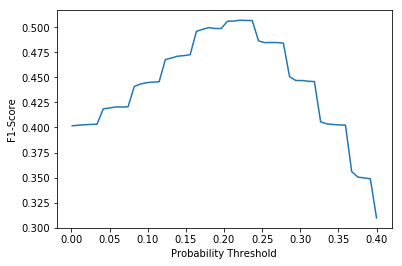

0.220857142857


In [34]:
## prob of being true in that genre
probs = np.array(y_guess_probs)[:, :, 1].T

thres_scores = []
thresholds = np.linspace(0.001, 0.4)
for threshold in thresholds:
    ylabels = np.array(probs > threshold, dtype=int)
    avg_f1_score = np.mean(f1_score(y_test, ylabels, average=None))
    thres_scores.append(avg_f1_score)

fig = plt.figure('Scores')
ax = fig.add_subplot(111)
ax.plot(thresholds, thres_scores)
ax.set_xlabel('Probability Threshold')
ax.set_ylabel('F1-Score')
plt.show()

print(thresholds[np.argmax(thres_scores)])

In [35]:
ylabels = np.array(probs > threshold, dtype=int)
scores = f1_score(y_test, ylabels, average=None)

for item in list(zip(labels, scores)):
    print(item)

('Action', 0.29159519725557459)
('Adventure', 0.19339622641509438)
('Comedy', 0.48189415041782724)
('Crime', 0.18276762402088773)
('Drama', 0.69166029074215751)
('Romance', 0.20947630922693267)
('Thriller', 0.11799410029498525)


In [43]:
# np.max(thres_scores)
np.mean(scores)

0.30982627119620842

In [42]:
# guess randomly
np.mean(f1_score(y_test, np.random.randint(0, 2, ylabels.shape), average=None))

0.32065311887027548